#Install Packages

In [ ]:
!pip install pulp
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, LpStatus, GLPK
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.6 MB/s eta 0:00:00


#Load Dataset

In [ ]:
# Load data from the specified URL
url = 'https://raw.githubusercontent.com/PhuphaB/Dissertation/main/ESPN_Top_40_Players.csv'
data = pd.read_csv(url, skiprows=[0]) # Skip the first row

In [ ]:
data.head(5)

,ESPN Ranking,Player,Team,Teams' IG Account Followers (Millions),Player Efficiency Rating (PER),Minutes Played,Clutch PPG,Win Shares,True Shooting %,IG Growth %,IG Engagement %,Player Total IG Followers (Millions),Average Google Trends Score (YouTube Search),All-Star Votes By Fans (Millions)
0,2,Luka Doncic,Los Angeles Lakers,25.32,24.1,1769,1.9,5.9,58.7,24.00,7.12,10.49,5.57,2.03
1,3,Giannis Antetokounmpo,Milwaukee Bucks,5.50,30.5,2289,2.9,11.5,62.5,1.26,1.79,15.99,32.38,4.44
2,4,Shai Gilgeous-Alexander,Oklahoma City Thunder,6.16,30.7,2598,3.0,16.7,63.7,69.19,10.73,4.01,41.86,3.15
3,5,Jayson Tatum,Boston Celtics,8.46,21.7,2624,3.0,9.5,58.2,10.60,5.22,7.30,32.21,3.61
4,6,Stephen Curry,Golden State Warriors,32.72,21.5,2252,3.6,7.9,61.8,6.20,0.77,58.11,29.22,2.34


In [ ]:
# Rename columns
data.columns = [
    'ESPN_Ranking', 'Player', 'Team', 'Team_IG_Followers_M',
    'PER', 'Minutes_Played', 'Clutch_PPG', 'Win_Shares',
    'True_Shooting_Pct', 'IG_Growth_Pct', 'IG_Engagement_Pct',
    'Player_IG_Followers_M', 'Google_Trends_Score', 'All_Star_Votes_M'
]

# Check updated column names
data.head()

,ESPN_Ranking,Player,Team,Team_IG_Followers_M,PER,Minutes_Played,Clutch_PPG,Win_Shares,True_Shooting_Pct,IG_Growth_Pct,IG_Engagement_Pct,Player_IG_Followers_M,Google_Trends_Score,All_Star_Votes_M
0,2,Luka Doncic,Los Angeles Lakers,25.32,24.1,1769,1.9,5.9,58.7,24.00,7.12,10.49,5.57,2.03
1,3,Giannis Antetokounmpo,Milwaukee Bucks,5.50,30.5,2289,2.9,11.5,62.5,1.26,1.79,15.99,32.38,4.44
2,4,Shai Gilgeous-Alexander,Oklahoma City Thunder,6.16,30.7,2598,3.0,16.7,63.7,69.19,10.73,4.01,41.86,3.15
3,5,Jayson Tatum,Boston Celtics,8.46,21.7,2624,3.0,9.5,58.2,10.60,5.22,7.30,32.21,3.61
4,6,Stephen Curry,Golden State Warriors,32.72,21.5,2252,3.6,7.9,61.8,6.20,0.77,58.11,29.22,2.34


In [ ]:
def run_dea(inputs_df, outputs_df, ar_constraint=False, return_weights=False, ar_lower_bound=0.05):

    inputs = inputs_df.values
    outputs = outputs_df.values
    player_names = data['Player'].values
    num_players = len(player_names)
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]

    efficiency_scores = {}
    optimal_weights = {}

    for i in range(num_players):
        prob = LpProblem(f"DEA_Player_{i}", LpMaximize)
        u = [LpVariable(f"u_{r}_{i}", lowBound=0) for r in range(num_outputs)]
        v = [LpVariable(f"v_{s}_{i}", lowBound=0) for s in range(num_inputs)]

        prob += lpSum(u[r] * outputs[i, r] for r in range(num_outputs))
        prob += lpSum(v[s] * inputs[i, s] for s in range(num_inputs)) == 1

        for j in range(num_players):
            prob += lpSum(u[r] * outputs[j, r] for r in range(num_outputs)) - \
                    lpSum(v[s] * inputs[j, s] for s in range(num_inputs)) <= 0

        if ar_constraint:
            sum_of_u_weights = lpSum(u)
            for r in range(num_outputs):
                prob += u[r] >= ar_lower_bound * sum_of_u_weights

        prob.solve()

        if LpStatus[prob.status] == 'Optimal':
            efficiency_scores[player_names[i]] = prob.objective.value()
            if return_weights:
                optimal_weights[player_names[i]] = {
                    'u': [var.value() for var in u],
                    'v': [var.value() for var in v]
                }
        else:
            efficiency_scores[player_names[i]] = None
            if return_weights:
                optimal_weights[player_names[i]] = None

    results_df = pd.DataFrame(list(efficiency_scores.items()), columns=['Player', 'Efficiency_Score'])

    if return_weights:
        return results_df, optimal_weights
    else:
        return results_df

#Model 2 with AR


In [ ]:
# Define inputs for Model 2 (Team_IG_Followers_M is removed)
input_cols_m2 = ['PER', 'Win_Shares', 'Minutes_Played', 'True_Shooting_Pct', 'Clutch_PPG']
output_cols_m2 = ['IG_Growth_Pct', 'IG_Engagement_Pct', 'Player_IG_Followers_M', 'All_Star_Votes_M', 'Google_Trends_Score']
model2_inputs = data[input_cols_m2]
model2_outputs = data[output_cols_m2]

# Run the DEA model with AR_constraint=True
model2_scores, model2_weights = run_dea(model2_inputs, model2_outputs, ar_constraint=True, return_weights=True)
model2_scores = model2_scores.sort_values(by='Efficiency_Score', ascending=False).reset_index(drop=True)

In [ ]:
  # Show and Save Scores
print("\n--- Results: Model 2 Individual Efficiency ---")
print(tabulate(model2_scores, headers='keys', tablefmt='fancy_grid', showindex=False))
model2_scores.to_csv('model_2_with_ar_scores.csv', index=False)
print("\nScores saved to 'model_2_with_ar_scores.csv'")



--- Results: Model 2 Individual Efficiency ---
╒═════════════════════════╤════════════════════╕
│ Player                  │   Efficiency_Score │
╞═════════════════════════╪════════════════════╡
│ Paul George             │           1        │
├─────────────────────────┼────────────────────┤
│ Jrue Holiday            │           1        │
├─────────────────────────┼────────────────────┤
│ Victor Wembenyama       │           1        │
├─────────────────────────┼────────────────────┤
│ Brandon Ingram          │           1        │
├─────────────────────────┼────────────────────┤
│ Kawhi Leonard           │           1        │
├─────────────────────────┼────────────────────┤
│ Chet Holmgren           │           1        │
├─────────────────────────┼────────────────────┤
│ Joel Embiid             │           1        │
├─────────────────────────┼────────────────────┤
│ Anthony Edwards         │           1        │
├─────────────────────────┼────────────────────┤
│ Lebron James       

In [ ]:
# Process and Save Weights
weights_data_m2 = []
for player, w in model2_weights.items():
    if w:
        row = {'Player': player}
        for i, col in enumerate(output_cols_m2):
            row[f'u_{col}'] = w['u'][i]
        for i, col in enumerate(input_cols_m2):
            row[f'v_{col}'] = w['v'][i]
        weights_data_m2.append(row)
weights_df_m2 = pd.DataFrame(weights_data_m2)
weights_df_m2.to_csv('model_2_with_ar_weights.csv', index=False)
print("Optimal weights saved to 'model_2_with_ar_weights.csv'")

Optimal weights saved to 'model_2_with_ar_weights.csv'


/tmp/ipython-input-1056530611.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Efficiency_Score', y='Player', data=model2_scores, palette='magma')


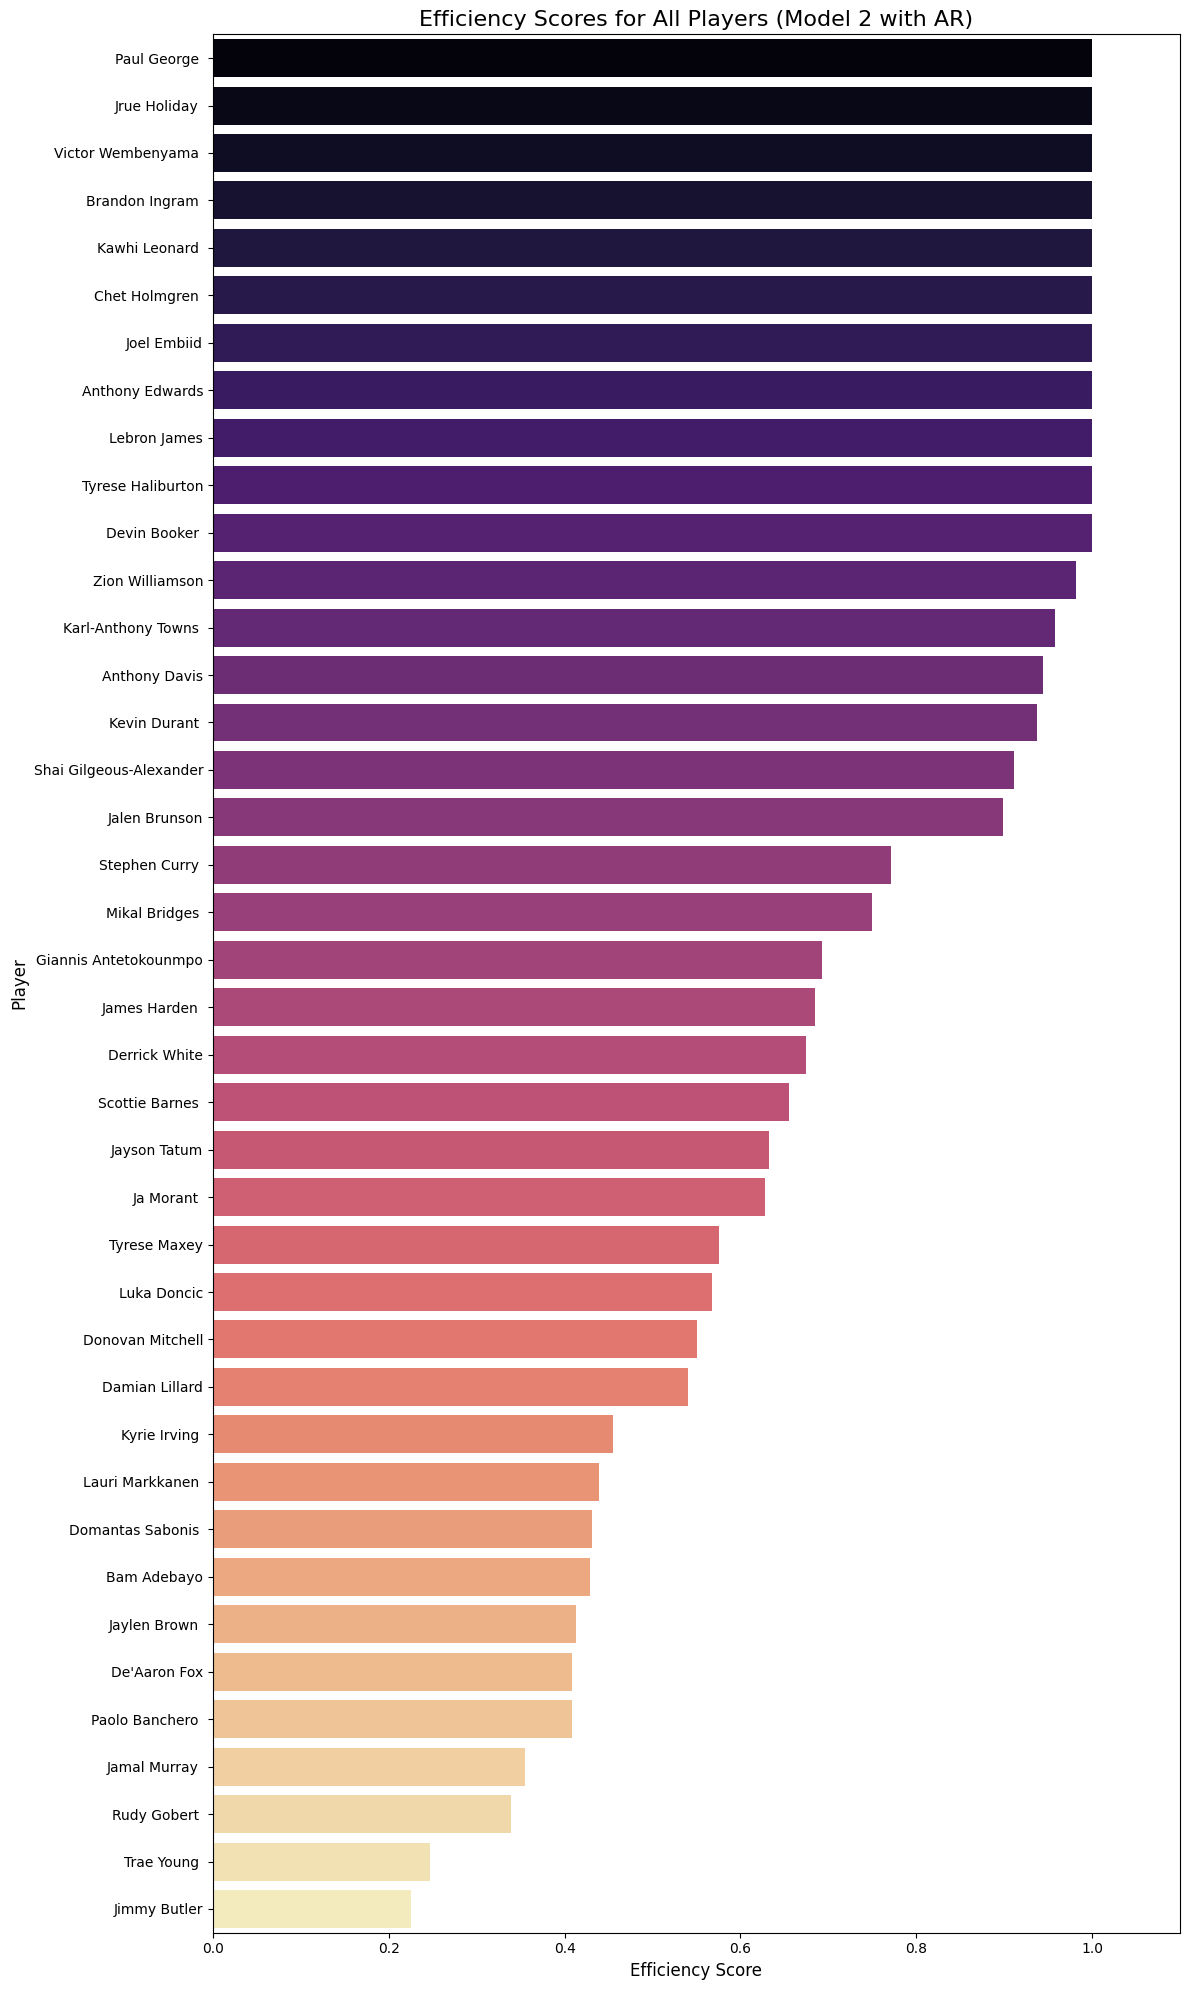

In [ ]:
# Visualization
plt.figure(figsize=(12, 20))
sns.barplot(x='Efficiency_Score', y='Player', data=model2_scores, palette='magma')
plt.title('Efficiency Scores for All Players (Model 2 with AR)', fontsize=16)
plt.xlabel('Efficiency Score', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()

# Model 2 Cross-Efficiency Matrix

In [ ]:
def calculate_cross_efficiency(inputs_df, outputs_df, all_weights):
    """Calculates the cross-efficiency matrix and final average scores."""
    inputs = inputs_df.values
    outputs = outputs_df.values
    player_names = data['Player'].values
    num_players = len(player_names)
    cross_efficiency_matrix = np.zeros((num_players, num_players))

    for i, i_player_name in enumerate(player_names):
        weights = all_weights.get(i_player_name)
        if weights is None: continue
        evaluator_u, evaluator_v = weights['u'], weights['v']

        for j, j_player_name in enumerate(player_names):
            weighted_outputs = np.sum(outputs[j, :] * evaluator_u)
            weighted_inputs = np.sum(inputs[j, :] * evaluator_v)
            score = weighted_outputs / weighted_inputs if weighted_inputs != 0 else 0
            cross_efficiency_matrix[i, j] = score

    final_cross_scores = np.mean(cross_efficiency_matrix, axis=0)
    scores_df = pd.DataFrame({'Player': player_names, 'Cross_Efficiency_Score': final_cross_scores})
    matrix_df = pd.DataFrame(cross_efficiency_matrix, index=player_names, columns=player_names)
    return matrix_df, scores_df


In [ ]:
# Calculate and Show Results
m2_matrix_df, m2_scores_df = calculate_cross_efficiency(model2_inputs, model2_outputs, model2_weights)

# Full Matrix
print("\n--- Full Cross-Efficiency Matrix (Model 2) ---")
print(m2_matrix_df.round(3))
m2_matrix_df.to_csv('model_2_cross_efficiency_matrix.csv')
print("\nFull matrix saved to 'model_2_cross_efficiency_matrix.csv'")


--- Full Cross-Efficiency Matrix (Model 2) ---
                         Luka Doncic  Giannis Antetokounmpo  \
Luka Doncic                    0.568                  0.443   
Giannis Antetokounmpo          0.316                  0.693   
Shai Gilgeous-Alexander        0.439                  0.433   
Jayson Tatum                   0.199                  0.631   
Stephen Curry                  0.316                  0.693   
Lebron James                   0.075                  0.085   
Joel Embiid                    0.231                  0.635   
Kevin Durant                   0.210                  0.489   
Anthony Edwards                0.249                  0.195   
Victor Wembenyama              0.415                  0.169   
Jalen Brunson                  0.340                  0.106   
Anthony Davis                  0.463                  0.458   
Jaylen Brown                   0.210                  0.489   
Devin Booker                   0.172                  0.614   
Tyrese 

In [ ]:
# Display and Save Final Ranked Scores
print("\n--- Final Cross-Efficiency Ranked Scores (Model 2) ---")
m2_scores_df['Rank'] = m2_scores_df['Cross_Efficiency_Score'].rank(method='min', ascending=False).astype(int)
m2_scores_df = m2_scores_df.sort_values(by='Cross_Efficiency_Score', ascending=False).reset_index(drop=True)
print(tabulate(m2_scores_df, headers='keys', tablefmt='fancy_grid', showindex=False))
m2_scores_df.to_csv('model_2_cross_efficiency_ranking.csv', index=False)
print("\nFinal ranking saved to 'model_2_cross_efficiency_ranking.csv'")



--- Final Cross-Efficiency Ranked Scores (Model 2) ---
╒═════════════════════════╤══════════════════════════╤════════╕
│ Player                  │   Cross_Efficiency_Score │   Rank │
╞═════════════════════════╪══════════════════════════╪════════╡
│ Anthony Edwards         │                 0.918459 │      1 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Jrue Holiday            │                 0.904968 │      2 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Victor Wembenyama       │                 0.819393 │      3 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Lebron James            │                 0.744684 │      4 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Kawhi Leonard           │                 0.738759 │      5 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Kevin Durant            │                 0.659763 │      6 │
├─────────────────────────┼─────────────────────

/tmp/ipython-input-715357656.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cross_Efficiency_Score', y='Player', data=m2_scores_df, palette='magma')


Visualization saved to 'model_2_cross_efficiency_chart_full.png'


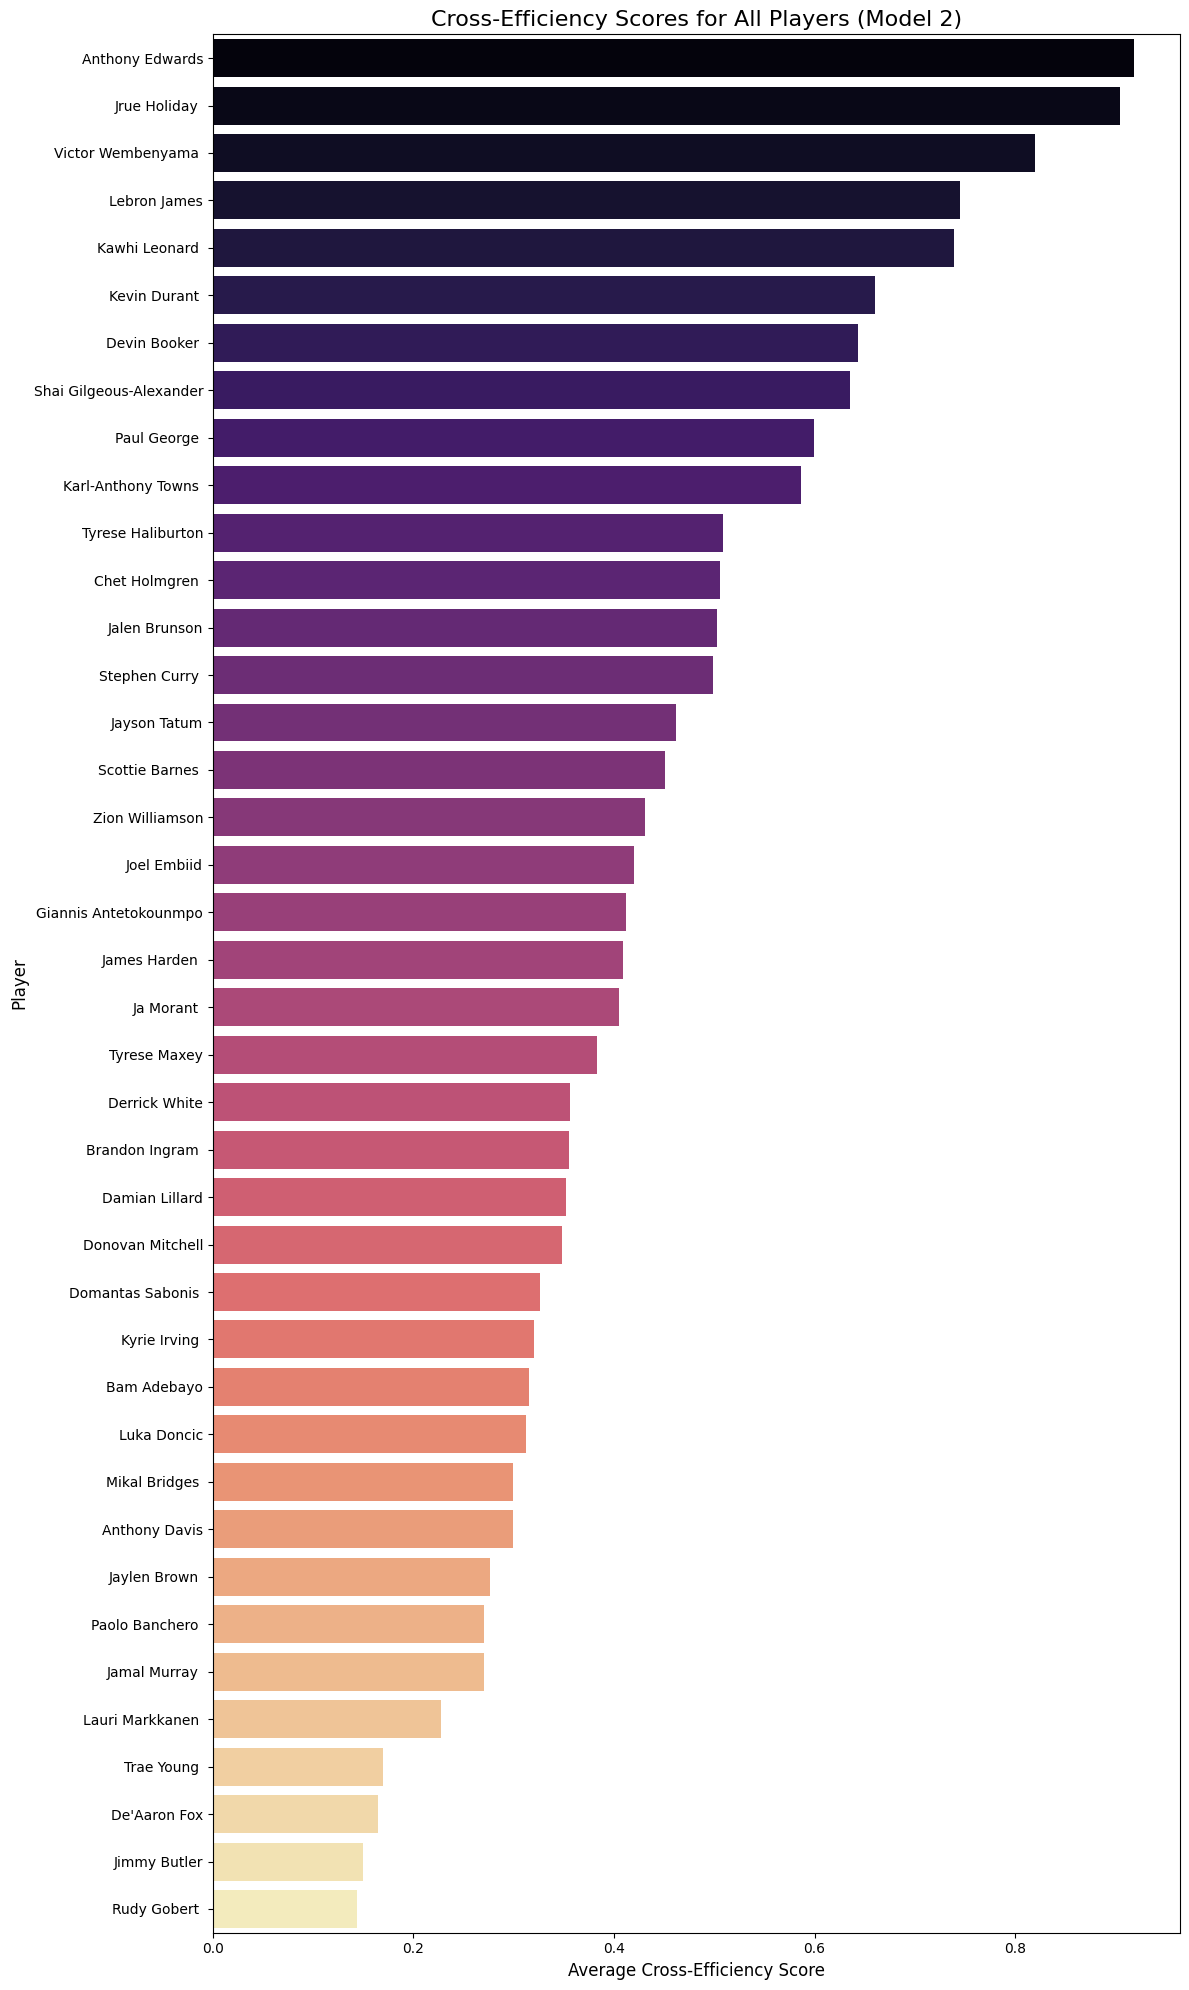

In [ ]:
# Visualization
plt.figure(figsize=(12, 20))
sns.barplot(x='Cross_Efficiency_Score', y='Player', data=m2_scores_df, palette='magma')
plt.title('Cross-Efficiency Scores for All Players (Model 2)', fontsize=16)
plt.xlabel('Average Cross-Efficiency Score', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.tight_layout()
plt.savefig('model_2_cross_efficiency_chart_full.png')
print("Visualization saved to 'model_2_cross_efficiency_chart_full.png'")
plt.show()